In [2]:
import arcpy
import os
import geopandas as gpd
import numpy as np


ModuleNotFoundError: No module named 'geopandas'

In [5]:
cyclone_path = r"G:\CASA\data\IBTrACSv4\IBTrACS.ALL.list.v04r00.lines\IBTrACS.ALL.list.v04r00.lines.shp"

In [7]:
cyclone_shape = gpd.read_file(cyclone_path)

In [16]:
columns_list = cyclone_shape.columns.to_list()

# Print the list of columns
for column in columns_list:
    print(column)

SID
SEASON
NUMBER
BASIN
SUBBASIN
NAME
ISO_TIME
NATURE
LAT
LON
WMO_WIND
WMO_PRES
WMO_AGENCY
TRACK_TYPE
DIST2LAND
LANDFALL
IFLAG
USA_AGENCY
USA_ATCFID
USA_LAT
USA_LON
USA_RECORD
USA_STATUS
USA_WIND
USA_PRES
USA_SSHS
USA_R34_NE
USA_R34_SE
USA_R34_SW
USA_R34_NW
USA_R50_NE
USA_R50_SE
USA_R50_SW
USA_R50_NW
USA_R64_NE
USA_R64_SE
USA_R64_SW
USA_R64_NW
USA_POCI
USA_ROCI
USA_RMW
USA_EYE
TOK_LAT
TOK_LON
TOK_GRADE
TOK_WIND
TOK_PRES
TOK_R50_DR
TOK_R50_L
TOK_R50_S
TOK_R30_DR
TOK_R30_L
TOK_R30_S
TOK_LAND
CMA_LAT
CMA_LON
CMA_CAT
CMA_WIND
CMA_PRES
HKO_LAT
HKO_LON
HKO_CAT
HKO_WIND
HKO_PRES
NEW_LAT
NEW_LON
NEW_GRADE
NEW_WIND
NEW_PRES
NEW_CI
NEW_DP
NEW_POCI
REU_LAT
REU_LON
REU_TYPE
REU_WIND
REU_PRES
REU_TNUM
REU_CI
REU_RMW
REU_R34_NE
REU_R34_SE
REU_R34_SW
REU_R34_NW
REU_R50_NE
REU_R50_SE
REU_R50_SW
REU_R50_NW
REU_R64_NE
REU_R64_SE
REU_R64_SW
REU_R64_NW
BOM_LAT
BOM_LON
BOM_TYPE
BOM_WIND
BOM_PRES
BOM_TNUM
BOM_CI
BOM_RMW
BOM_R34_NE
BOM_R34_SE
BOM_R34_SW
BOM_R34_NW
BOM_R50_NE
BOM_R50_SE
BOM_R50_SW
BOM_R50_NW


In [9]:
# Subset the shapefile
cyclone_shape = cyclone_shape[cyclone_shape['year'] > 1990]
cyclone_shape = cyclone_shape[cyclone_shape['DIST2LAND'] < 1500]

In [17]:
# Define the custom function to calculate the new field value
def calculate_wind(row):
    if row['USA_WIND'] > 0:
        return row['USA_WIND']
    else:
        return max(row['TOK_WIND'], row['CMA_WIND'], row['HKO_WIND'], row['NEW_WIND'], 
                   row['REU_WIND'], row['BOM_WIND'], row['NAD_WIND'], row['WEL_WIND'], row['NEU_WIND'])

# Apply the function to each row to create a new field
cyclone_shape['CIESI_WIND'] = cyclone_shape.apply(calculate_wind, axis=1)

In [18]:
cyclone_shape = cyclone_shape[cyclone_shape['CIESI_WIND'] >= 64]

In [19]:
cyclone_shape.to_file(r"G:\CASA\output_shapefiles\IBTrACS_Y1990p_64Kt.shp")

Polynomial model coefficients: a = 0.001723276721097955, b = -0.781068931072584, c = 94.00199800219099
Logarithmic model coefficients: a = -36.638462880247204, b = 201.11629936114252


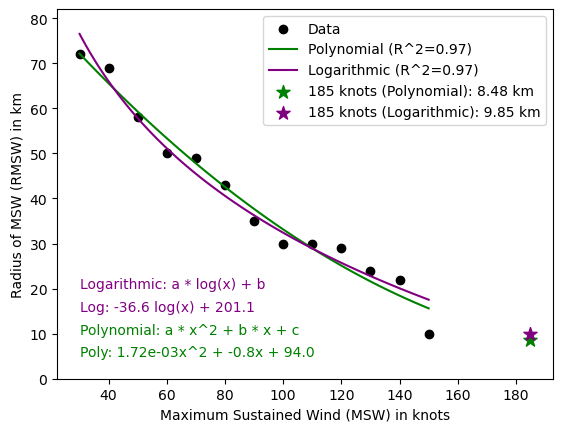

R-squared for polynomial model: 0.97
R-squared for logarithmic model: 0.97
RMSW for 185 knots MSW (Polynomial model): 8.48 km
RMSW for 185 knots MSW (Logarithmic model): 9.85 km


In [22]:

# Define the data points
x_data = np.array([30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150])  # MSW in knots
y_data = np.array([72, 69, 58, 50, 49, 43, 35, 30, 30, 29, 24, 22, 10])     # RMSW in km


# Define the polynomial function
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Define the logarithmic function
def log_model(x, a, b):
    return a * np.log(x) + b

# Fit the polynomial model to the data
popt_poly, _ = curve_fit(poly_func, x_data, y_data)
y_fit_poly = poly_func(x_data, *popt_poly)
r2_poly = r2_score(y_data, y_fit_poly)

# Fit the logarithmic model to the data
popt_log, _ = curve_fit(log_model, x_data, y_data)
y_fit_log = log_model(x_data, *popt_log)
r2_log = r2_score(y_data, y_fit_log)

# Generate a range of x values for plotting
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit_poly_full = poly_func(x_fit, *popt_poly)
y_fit_log_full = log_model(x_fit, *popt_log)

# Calculate the RMSW for a cyclone with 185 knots MSW
msw_value = 185
rmsw_poly = poly_func(msw_value, *popt_poly)
rmsw_log = log_model(msw_value, *popt_log)

# Plot the data and the fitted models
plt.scatter(x_data, y_data, label='Data', color='black')
plt.plot(x_fit, y_fit_poly_full, label=f'Polynomial (R^2={r2_poly:.2f})', color='green')
plt.plot(x_fit, y_fit_log_full, label=f'Logarithmic (R^2={r2_log:.2f})', color='purple')
plt.scatter([msw_value], [rmsw_poly], color='green', marker='*', s=100, label=f'185 knots (Polynomial): {rmsw_poly:.2f} km')
plt.scatter([msw_value], [rmsw_log], color='purple', marker='*', s=100, label=f'185 knots (Logarithmic): {rmsw_log:.2f} km')
plt.xlabel('Maximum Sustained Wind (MSW) in knots')
plt.ylabel('Radius of MSW (RMSW) in km')
plt.ylim(0, max(y_data) + 10)  # Set y-axis to start at 0 and add a bit of padding at the top

# Add the equations to the plot
plt.text(30, 5, f'Poly: {popt_poly[0]:.2e}x^2 + {popt_poly[1]:.2e}x + {popt_poly[2]:.2e}', color='green')
plt.text(30, 10, f'Log: {popt_log[0]:.2e}log(x) + {popt_log[1]:.2e}', color='purple')

plt.legend()
plt.show()

# Print R-squared values
print(f'R-squared for polynomial model: {r2_poly:.2f}')
print(f'R-squared for logarithmic model: {r2_log:.2f}')

# Print RMSW for 185 knots MSW
print(f'RMSW for 185 knots MSW (Polynomial model): {rmsw_poly:.2f} km')
print(f'RMSW for 185 knots MSW (Logarithmic model): {rmsw_log:.2f} km')
# Define the polynomial function
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Define the logarithmic function
def log_model(x, a, b):
    return a * np.log(x) + b

# Fit the polynomial model to the data
popt_poly, _ = curve_fit(poly_func, x_data, y_data)
y_fit_poly = poly_func(x_data, *popt_poly)
r2_poly = r2_score(y_data, y_fit_poly)

# Fit the logarithmic model to the data
popt_log, _ = curve_fit(log_model, x_data, y_data)
y_fit_log = log_model(x_data, *popt_log)
r2_log = r2_score(y_data, y_fit_log)

# Extract the coefficients
a_poly, b_poly, c_poly = popt_poly
a_log, b_log = popt_log

# Print the coefficients
print(f'Polynomial model coefficients: a = {a_poly}, b = {b_poly}, c = {c_poly}')
print(f'Logarithmic model coefficients: a = {a_log}, b = {b_log}')

# Generate a range of x values for plotting
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit_poly_full = poly_func(x_fit, *popt_poly)
y_fit_log_full = log_model(x_fit, *popt_log)

# Calculate the RMSW for a cyclone with 185 knots MSW
msw_value = 185
rmsw_poly = poly_func(msw_value, *popt_poly)
rmsw_log = log_model(msw_value, *popt_log)

# Plot the data and the fitted models
plt.scatter(x_data, y_data, label='Data', color='black')
plt.plot(x_fit, y_fit_poly_full, label=f'Polynomial (R^2={r2_poly:.2f})', color='green')
plt.plot(x_fit, y_fit_log_full, label=f'Logarithmic (R^2={r2_log:.2f})', color='purple')
plt.scatter([msw_value], [rmsw_poly], color='green', marker='*', s=100, label=f'185 knots (Polynomial): {rmsw_poly:.2f} km')
plt.scatter([msw_value], [rmsw_log], color='purple', marker='*', s=100, label=f'185 knots (Logarithmic): {rmsw_log:.2f} km')
plt.xlabel('Maximum Sustained Wind (MSW) in knots')
plt.ylabel('Radius of MSW (RMSW) in km')
plt.ylim(0, max(y_data) + 10)  # Set y-axis to start at 0 and add a bit of padding at the top

# Add the equations to the plot with the specific a, b, and c values
plt.text(30, 5, f'Poly: {a_poly:.2e}x^2 + {b_poly:.1f}x + {c_poly:.1f}', color='green')
plt.text(30, 10, 'Polynomial: a * x^2 + b * x + c', color='green')
plt.text(30, 15, f'Log: {a_log:.1f} log(x) + {b_log:.1f}', color='purple')
plt.text(30, 20, 'Logarithmic: a * log(x) + b', color='purple')

plt.legend()
plt.show()

# Print R-squared values
print(f'R-squared for polynomial model: {r2_poly:.2f}')
print(f'R-squared for logarithmic model: {r2_log:.2f}')

# Print RMSW for 185 knots MSW
print(f'RMSW for 185 knots MSW (Polynomial model): {rmsw_poly:.2f} km')
print(f'RMSW for 185 knots MSW (Logarithmic model): {rmsw_log:.2f} km')

In [ ]:
#use logarithmic formula to calculate radius in km and multiplied it by 1,000 fot meters
cyclone_shape['CIESIN_rMSW'] = (-36.6 * np.log(cyclone_shape['CIESIN_WIND']) + 201.1) * 1000

In [ ]:
buff_shape = r"G:\CASA\CASA-project\CASA-project.gdb\IBTrACSBuff.shp"
arcpy.analysis.PairwiseBuffer(
    in_features=cyclone_shape,
    out_feature_class=buff_shape,
    buffer_distance_or_field="CIESIN_rMSW",
    dissolve_option="ALL",
    dissolve_field=None,
    method="GEODESIC",
    max_deviation="0 DecimalDegrees"
)

In [ ]:
Cities_IBTrACS_Y1990p_64Kt_rMSWBuff = r"G:\CASA\output_shapefiles\Cities_IBTrACS_Y1990p_64Kt_rMSWBuff.shp"
arcpy.analysis.PairwiseClip(
    in_features=buff_shape,
    clip_features="main.cities_dataset_progress_7_11",
    out_feature_class= Cities_IBTrACS_Y1990p_64Kt_rMSWBuff,
    cluster_tolerance=None
)

In [ ]:
Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_USA = r"G:\CASA\output_shapefiles\Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_USA.shp"

# Define the SQL query
sql_query = '"USA_WIND" > 0'

# Create a feature layer with the SQL query
arcpy.MakeFeatureLayer_management(Cities_IBTrACS_Y1990p_64Kt_rMSWBuff, "temp_layer", sql_query)

# Save the feature layer to a new feature class
arcpy.CopyFeatures_management("temp_layer", Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_USA)

In [ ]:
#add a new field/column named 'binary'
arcpy.management.AddField(
    in_table=Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_USA,
    field_name="binary",
    field_type="SHORT",
    field_precision=None,
    field_scale=None,
    field_length=None,
    field_alias="",
    field_is_nullable="NULLABLE",
    field_is_required="NON_REQUIRED",
    field_domain=""
)

In [ ]:
arcpy.management.CalculateField(
    in_table=Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_USA,
    field="binary",
    expression="1",
    expression_type="PYTHON3",
    code_block="",
    field_type="TEXT",
    enforce_domains="NO_ENFORCE_DOMAINS"
)


In [ ]:
Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_Merged_USA = r"G:\CASA\output_shapefiles\Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_Merged_USA.shp"
arcpy.analysis.PairwiseDissolve(
    in_features=Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_USA,
    out_feature_class=Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_Merged_USA,
    dissolve_field="Binary",
    statistics_fields=None,
    multi_part="SINGLE_PART",
    concatenation_separator=""
)

In [ ]:
Cities_IBTrACS_1990p_64Kt_rBuff_Merg_USA_Erase = r"G:\CASA\output_shapefiles\Cities_IBTrACS_1990p_64Kt_rBuff_Merg_USA_Erase.shp"
arcpy.analysis.PairwiseErase(
    in_features="main.cities_dataset_progress_7_18",
    erase_features=Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_Merged_USA,
    out_feature_class=Cities_IBTrACS_1990p_64Kt_rBuff_Merg_USA_Erase,
    cluster_tolerance=None
)

In [ ]:
Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_Merg_Binary_USA = r"G:\CASA\output_shapefiles\Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_Merg_Binary_USA.shp"
arcpy.management.Merge(
    inputs="Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_Merged_USA;Cities_IBTrACS_1990p_64Kt_rBuff_Merg_USA_Erase",
    output=Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_Merg_Binary_USA,
    field_mappings='binary "binary" true true false 5 Long 0 5,First,#,Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_Merged_USA,binary,-1,-1',
    add_source="NO_SOURCE_INFO"
)

In [ ]:
arcpy.analysis.Union(
    in_features="Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_Merged_USA #;cities_dataset_final #",
    out_feature_class=r"C:\Users\ejenliu\Documents\ArcGIS\Projects\MyProject1\myproject1.gdb\Cities_IBTrACS_Y1990p__Union",
    join_attributes="ALL",
    cluster_tolerance=None,
    gaps="GAPS"
)

In [ ]:
arcpy.conversion.ExportFeatures(
    in_features="Cities_IBTrACS_Y1990p__Union",
    out_features=r"G:\CASA\ejen\Subcity Shapefiles\Not cleaned\cyclone_union.shp",
    where_clause="",
    use_field_alias_as_name="NOT_USE_ALIAS",
    field_mapping='FID_Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_Merged_USA "FID_Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_Merged_USA" true true false 4 Long 0 0,First,#,Cities_IBTrACS_Y1990p__Union,FID_Cities_IBTrACS_Y1990p_64Kt_rMSWBuff_Merged_USA,-1,-1;binary "binary" true true false 4 Long 0 0,First,#,Cities_IBTrACS_Y1990p__Union,binary,-1,-1;FID_cities_dataset_final "FID_cities_dataset_final" true true false 4 Long 0 0,First,#,Cities_IBTrACS_Y1990p__Union,FID_cities_dataset_final,-1,-1;ID_HDC_G0 "ID_HDC_G0" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,ID_HDC_G0,-1,-1;UC_NM_MN "UC_NM_MN" true true false 80 Text 0 0,First,#,Cities_IBTrACS_Y1990p__Union,UC_NM_MN,0,80;UC_NM_LST "UC_NM_LST" true true false 254 Text 0 0,First,#,Cities_IBTrACS_Y1990p__Union,UC_NM_LST,0,254;CTR_MN_NM "CTR_MN_NM" true true false 80 Text 0 0,First,#,Cities_IBTrACS_Y1990p__Union,CTR_MN_NM,0,80;REG_GHSL "REG_GHSL" true true false 80 Text 0 0,First,#,Cities_IBTrACS_Y1990p__Union,REG_GHSL,0,80;REG_USAID "REG_USAID" true true false 80 Text 0 0,First,#,Cities_IBTrACS_Y1990p__Union,REG_USAID,0,80;IN_USAID "IN_USAID" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,IN_USAID,-1,-1;P15 "P15" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,P15,-1,-1;P20 "P20" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,P20,-1,-1;P25 "P25" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,P25,-1,-1;P20_25 "P20_25" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,P20_25,-1,-1;P20_25_CAT "P20_25_CAT" true true false 80 Text 0 0,First,#,Cities_IBTrACS_Y1990p__Union,P20_25_CAT,0,80;P20_25_BIN "P20_25_BIN" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,P20_25_BIN,-1,-1;P25_CAT "P25_CAT" true true false 80 Text 0 0,First,#,Cities_IBTrACS_Y1990p__Union,P25_CAT,0,80;P25_SMMED "P25_SMMED" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,P25_SMMED,-1,-1;P_AGE_U15 "P_AGE_U15" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,P_AGE_U15,-1,-1;P_AGE_65UP "P_AGE_65UP" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,P_AGE_65UP,-1,-1;P_AGE_DEP "P_AGE_DEP" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,P_AGE_DEP,-1,-1;GDP15 "GDP15" true true false 4 Long 0 0,First,#,Cities_IBTrACS_Y1990p__Union,GDP15,-1,-1;GDP15_PER "GDP15_PER" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,GDP15_PER,-1,-1;P00_20 "P00_20" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,P00_20,-1,-1;P00_20_MIG "P00_20_MIG" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,P00_20_MIG,-1,-1;D_1M "D_1M" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,D_1M,-1,-1;D_1M_NM "D_1M_NM" true true false 80 Text 0 0,First,#,Cities_IBTrACS_Y1990p__Union,D_1M_NM,0,80;D_500K "D_500K" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,D_500K,-1,-1;D_500K_NM "D_500K_NM" true true false 80 Text 0 0,First,#,Cities_IBTrACS_Y1990p__Union,D_500K_NM,0,80;L_DRY "L_DRY" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,L_DRY,-1,-1;L_COAST "L_COAST" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,L_COAST,-1,-1;L_ELEV "L_ELEV" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,L_ELEV,-1,-1;RISK_TEMP_ "RISK_TEMP_" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,RISK_TEMP_,-1,-1;RISK_WBGT_ "RISK_WBGT_" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,RISK_WBGT_,-1,-1;RISK_TEMP "RISK_TEMP" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,RISK_TEMP,-1,-1;RISK_WBGT "RISK_WBGT" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,RISK_WBGT,-1,-1;RISK_SCAR "RISK_SCAR" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,RISK_SCAR,-1,-1;RISK_RIVR_ "RISK_RIVR_" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,RISK_RIVR_,-1,-1;RISK_RIVR "RISK_RIVR" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,RISK_RIVR,-1,-1;RISK_SURG_ "RISK_SURG_" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,RISK_SURG_,-1,-1;RISK_SURG "RISK_SURG" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,RISK_SURG,-1,-1;RISK_CYC1 "RISK_CYC1" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,RISK_CYC1,-1,-1;RISK_CYC2 "RISK_CYC2" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,RISK_CYC2,-1,-1;RISK_LAND "RISK_LAND" true true false 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,RISK_LAND,-1,-1;unique_id "unique_id" true true false 254 Text 0 0,First,#,Cities_IBTrACS_Y1990p__Union,unique_id,0,254;Shape_Length "Shape_Length" false true true 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,Shape_Length,-1,-1;Shape_Area "Shape_Area" false true true 8 Double 0 0,First,#,Cities_IBTrACS_Y1990p__Union,Shape_Area,-1,-1',
    sort_field=None
)